## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# for simran
# %cd /content/drive/MyDrive/Colab\ Notebooks
# df = pd.read_csv('IPLdataset.csv')

In [4]:
# for kushagra
%cd /content/drive/MyDrive/

/content/drive/MyDrive


## Dataset exploration and preprocessing

### Read df and functions for normalizing

In [5]:
df = pd.read_csv('IPL Ball-by-Ball 2008-2020.csv')
df = df.where(df["id"]>=829705).reset_index()

In [6]:
def normalize(df):
    '''
      Helper function to perform min-max normalization
      on dataframe columns
      :param df: input dataframe
      :type df: pandas dataframe
    '''
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def reverseNormalize(df):
    '''
      Helper function to perform min-max denormalization
      on dataframe columns
      :param df: input dataframe
      :type df: pandas dataframe
    '''
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = 1-(df[feature_name] - min_value) / (max_value - min_value)
    return result

### Batsmen matrix computation

In [7]:
# cell to calculate average runs scored by every batsman
batsmanAvgRunsCommon = df.groupby(["batsman","id"])[["batsman_runs"]].sum().groupby(["batsman"]).mean()
batsmanAvgRunsCommon = normalize(batsmanAvgRunsCommon)

In [8]:
# cell to calculate average catches for every batsman
batsmanAvgCatchesCommon = df.groupby(["fielder","id"])[["is_wicket"]].sum().groupby(["fielder"]).mean()
batsmanAvgCatchesCommon = normalize(pd.merge(batsmanAvgCatchesCommon, df["batsman"], left_on='fielder', right_on='batsman', how = "right").groupby(["batsman"]).mean()).fillna(0)

In [9]:
# cell to calculate average runs scored by every pair of batsmen against common bowlers
batsmanAvgRunsBowler = df.groupby(["batsman","bowler","id"])[["batsman_runs"]].sum().groupby(["batsman","bowler"]).mean()
batsmanAvgRunsBowler1 = batsmanAvgRunsBowler.rename({"batsman":"batsman1", "batsman_runs": "batsman_runs1"}).reset_index()
batsmanAvgRunsBowler2 = batsmanAvgRunsBowler.rename({"batsman":"batsman2",  "batsman_runs": "batsman_runs2"}).reset_index()


batsmanAvgRunsPairwise = batsmanAvgRunsBowler1.merge(batsmanAvgRunsBowler2, left_on='bowler', right_on='bowler')
batsmanAvgRunsPairwise = batsmanAvgRunsPairwise.where(batsmanAvgRunsPairwise["batsman_x"]!=batsmanAvgRunsPairwise["batsman_y"]).dropna()
batsmanAvgRunsPairwise = normalize(batsmanAvgRunsPairwise.groupby(["batsman_x","batsman_y"]).sum())
print(batsmanAvgRunsPairwise.head())

                               batsman_runs_x  batsman_runs_y
batsman_x      batsman_y                                     
A Ashish Reddy A Mishra              0.047918        0.015226
               A Nehra               0.006270        0.001791
               A Zampa               0.001791        0.000000
               AB de Villiers        0.065832        0.127647
               AD Hales              0.026870        0.017018


In [10]:
# cell to calculate average count of dismissals for every pair of batsmen against common bowlers
batsmanAvgWicketsBowler = df.groupby(["batsman","bowler","id"])[["is_wicket"]].sum().groupby(["batsman","bowler"]).mean()
batsmanAvgWicketsBowler1 = batsmanAvgWicketsBowler.rename({"batsman":"batsman1", "batsman_runs": "batsman_runs1"}).reset_index()
batsmanAvgWicketsBowler2 = batsmanAvgWicketsBowler.rename({"batsman":"batsman2",  "batsman_runs": "batsman_runs2"}).reset_index()


batsmanAvgWicketsPairwise = batsmanAvgWicketsBowler1.merge(batsmanAvgWicketsBowler2, left_on='bowler', right_on='bowler')
batsmanAvgWicketsPairwise = batsmanAvgWicketsPairwise.where(batsmanAvgWicketsPairwise["batsman_x"]!=batsmanAvgWicketsPairwise["batsman_y"]).dropna()
batsmanAvgWicketsPairwise = reverseNormalize(batsmanAvgWicketsPairwise.groupby(["batsman_x","batsman_y"]).sum())
print(batsmanAvgWicketsPairwise.head())

                               is_wicket_x  is_wicket_y
batsman_x      batsman_y                               
A Ashish Reddy A Mishra           0.947421     0.929895
               A Nehra            0.929895     0.964947
               A Zampa            1.000000     0.964947
               AB de Villiers     0.842263     0.877900
               AD Hales           1.000000     0.982474


In [11]:
'''
  Final calculation of scores for every batsmen
  Score for a batsman is a weighted sum of the following
    (0.3 x average runs scored) + (0.1 x count of dismissal (reverse_normalised)) +
    (0.3 x difference of runs between players a and b) + (0.3 x difference of dismissals between players a and b)
'''

P_batsman = batsmanAvgCatchesCommon.merge(batsmanAvgRunsCommon, on = "batsman").reset_index()
P_batsman["common_metric"] = 0.3*P_batsman["batsman_runs"]+ 0.1*P_batsman["is_wicket"]
P_batsman = P_batsman[["batsman", "common_metric"]].reset_index()
batsman_list = list(df["batsman"].dropna().unique())
batsman_list = sorted(batsman_list)
P_batsman["batsman2"] = [batsman_list for i in P_batsman.index]


P_batsman_pairs = P_batsman.explode("batsman2")
P_batsman_pairs = P_batsman_pairs.merge(batsmanAvgWicketsPairwise.reset_index(), left_on=["batsman","batsman2"], right_on=["batsman_x","batsman_y"], how="left")
P_batsman_pairs = P_batsman_pairs.reset_index()
P_batsman_pairs = P_batsman_pairs[["batsman","batsman2","common_metric","is_wicket_x","is_wicket_y"]].reset_index().fillna(0)

P_batsman_pairs = P_batsman_pairs.merge(batsmanAvgRunsPairwise.reset_index(), left_on=["batsman","batsman2"], right_on=["batsman_x","batsman_y"], how="left")
P_batsman_pairs = P_batsman_pairs.reset_index()
P_batsman_pairs = P_batsman_pairs[["batsman","batsman2","common_metric","is_wicket_x","is_wicket_y","batsman_runs_x","batsman_runs_y"]].reset_index().fillna(0)

P_batsman_pairs["common_metric"] = P_batsman_pairs["common_metric"]+0.3*P_batsman_pairs["batsman_runs_x"]+0.3*P_batsman_pairs["is_wicket_x"]
P_batsman_pairs = P_batsman_pairs.sort_values(by=['batsman'])
P_batsman_pairs = P_batsman_pairs[["batsman","batsman2","common_metric"]]

P_batsman_matrix = P_batsman_pairs[["common_metric"]].to_numpy().reshape(len(batsman_list)*len(batsman_list)).reshape((len(batsman_list),len(batsman_list)))

### Bowler matrix computation

In [12]:
# cell to compute average runs conceded by a bowler
bowlerAvgRunsCommon = df.groupby(["bowler","id"])[["batsman_runs"]].sum().groupby(["bowler"]).mean()
bowlerAvgRunsCommon = reverseNormalize(bowlerAvgRunsCommon)

In [13]:
# cell to compute extra runs (wides, no balls etc) by a bowler
bowlerAvgExtrasCommon = df.groupby(["bowler","id"])[["extra_runs"]].sum().groupby(["bowler"]).mean()
bowlerAvgExtrasCommon = reverseNormalize(bowlerAvgExtrasCommon)

In [14]:
# cell to compute catches taken by a bowler
bowlerAvgCatchesCommon = df.groupby(["fielder","id"])[["is_wicket"]].sum().groupby(["fielder"]).mean()
bowlerAvgCatchesCommon = normalize(pd.merge(bowlerAvgCatchesCommon, df["bowler"], left_on='fielder', right_on='bowler', how = "right").groupby(["bowler"]).mean()).fillna(0)
bowlerAvgCatchesCommon = bowlerAvgCatchesCommon.rename(columns = {"is_wicket": "catches"}).reset_index()

In [15]:
# cell to compute wickets taken by a bowler
bowlerAvgWicketsCommon = df.groupby(["bowler","id"])[["is_wicket"]].sum().groupby(["bowler"]).mean()
bowlerAvgWicketsCommon = normalize(bowlerAvgWicketsCommon)

In [16]:
# cell to compute runs conceded by two bowlers for every batsman
bowlerAvgRunsBatsman = df.groupby(["bowler","batsman","id"])[["batsman_runs"]].sum().groupby(["bowler","batsman"]).mean()
bowlerAvgRunsBatsman1 = bowlerAvgRunsBatsman.rename({"bowler":"bowler1"}).reset_index()
bowlerAvgRunsBatsman2 = bowlerAvgRunsBatsman.rename({"bowler":"bowler2"}).reset_index()


bowlerAvgRunsPairwise = bowlerAvgRunsBatsman1.merge(bowlerAvgRunsBatsman2, left_on='batsman', right_on='batsman')
bowlerAvgRunsPairwise = bowlerAvgRunsPairwise.where(bowlerAvgRunsPairwise["bowler_x"]!=bowlerAvgRunsPairwise["bowler_y"]).dropna()
bowlerAvgRunsPairwise = reverseNormalize(bowlerAvgRunsPairwise.groupby(["bowler_x","bowler_y"]).sum())
print(bowlerAvgRunsPairwise.head())

                            batsman_runs_x  batsman_runs_y
bowler_x       bowler_y                                   
A Ashish Reddy A Choudhary        0.981017        0.958582
               A Dananjaya        0.965485        0.986194
               A Mishra           0.919752        0.828311
               A Nehra            0.911123        0.852907
               A Nortje           0.954267        0.922340


In [17]:
# cell to compute wickets taken by two bowlers for every batsman
bowlerAvgWicketsBatsman = df.groupby(["bowler","batsman","id"])[["is_wicket"]].sum().groupby(["bowler","batsman"]).mean()
bowlerAvgWicketsBatsman1 = bowlerAvgWicketsBatsman.rename({"bowler":"bowler1", "is_wicket": "is_wicket1"}).reset_index()
bowlerAvgWicketsBatsman2 = bowlerAvgWicketsBatsman.rename({"bowler":"bowler2",  "is_wicket": "is_wicket2"}).reset_index()


bowlerAvgWicketsPairwise = bowlerAvgWicketsBatsman1.merge(bowlerAvgWicketsBatsman2, left_on='batsman', right_on='batsman')
bowlerAvgWicketsPairwise = bowlerAvgWicketsPairwise.where(bowlerAvgWicketsPairwise["bowler_x"]!=bowlerAvgWicketsPairwise["bowler_y"]).dropna()
bowlerAvgWicketsPairwise = normalize(bowlerAvgWicketsPairwise.groupby(["bowler_x","bowler_y"]).sum())
print(bowlerAvgWicketsPairwise.head())

                            is_wicket_x  is_wicket_y
bowler_x       bowler_y                             
A Ashish Reddy A Choudhary     0.033613     0.000000
               A Dananjaya     0.000000     0.000000
               A Mishra        0.134454     0.071469
               A Nehra         0.100840     0.091877
               A Nortje        0.100840     0.117647


In [18]:
'''
  Final calculation of scores for every bowlers
  Score for a bowler is a weighted sum of the following
    (0.2 x average runs conceded (reverse normalized)) + (0.1 x catches taken) +
    (0.3 x average wickets taken) + (0.2 x difference of runs conceded between bowlers a and b) + 
    (0.2 x difference of wickets taken between bowlers a and b)
'''

P_bowler = bowlerAvgCatchesCommon.merge(bowlerAvgRunsCommon, on = "bowler")
P_bowler = P_bowler.merge(bowlerAvgExtrasCommon, on = "bowler")
P_bowler = P_bowler.merge(bowlerAvgWicketsCommon, on = "bowler").reset_index()

P_bowler["common_metric"] = 0.2*P_bowler["batsman_runs"]+0.1*P_bowler["catches"]+ 0.3*P_bowler["is_wicket"]
P_bowler = P_bowler[["bowler", "common_metric"]].reset_index()
bowler_list = list(df["bowler"].dropna().unique())
bowler_list = sorted(bowler_list)
P_bowler["bowler2"] = [bowler_list for i in P_bowler.index]


P_bowler_pairs = P_bowler.explode("bowler2")
P_bowler_pairs = P_bowler_pairs.merge(bowlerAvgWicketsPairwise.reset_index(), left_on=["bowler","bowler2"], right_on=["bowler_x","bowler_y"], how="left")
P_bowler_pairs = P_bowler_pairs.reset_index()
P_bowler_pairs = P_bowler_pairs[["bowler","bowler2","common_metric","is_wicket_x"]].reset_index().fillna(0)


P_bowler_pairs = P_bowler_pairs.merge(bowlerAvgRunsPairwise.reset_index(), left_on=["bowler","bowler2"], right_on=["bowler_x","bowler_y"], how="left")
P_bowler_pairs = P_bowler_pairs.reset_index()
P_bowler_pairs = P_bowler_pairs[["bowler","bowler2","common_metric","is_wicket_x","batsman_runs_x"]].reset_index().fillna(0)

P_bowler_pairs["common_metric"] = P_bowler_pairs["common_metric"]+0.2*P_bowler_pairs["batsman_runs_x"]+0.2*P_bowler_pairs["is_wicket_x"]
P_bowler_pairs = P_bowler_pairs.sort_values(by=['bowler'])
P_bowler_pairs = P_bowler_pairs[["bowler","bowler2","common_metric"]]

P_bowler_matrix = P_bowler_pairs[["common_metric"]].to_numpy().reshape(len(bowler_list)*len(bowler_list)).reshape((len(bowler_list),len(bowler_list)))

## PageRank computation

In [19]:
class PageRank(object):
    def __init__(self, alpha, P) -> None:
        '''
            Constructor for the class
            :param W: Input graph
            :type W: nxn numpy array
            :param alpha: dampening factor
            :type alpha: float
            :param P: Transition matrix
            :type P: nxn numpy array
        '''
        # self.graph = W
        self.alpha = alpha
        self.P = P
        self.n = P.shape[0]
        self.num_iter = 0
        self.v_over_iter = list()
        self.num_rank = self.n
    
    def makeTransitionMatrixRegular(self):
        '''
            Function to convert the transition matrix into
            a regular matrix
            :return: nxn regular matrix P
        '''
        for i in range(self.P.shape[1]):
            if(np.all((self.P[:,i] == 0))):
                self.P[:,i] = 1/(self.n)
        P = (1 - self.alpha)*self.P + (self.alpha / self.n)
        return P

    def stoppingCondition(self, v_prev, v_curr):
        '''
            Function to calculate the norm between the previous
            and current set of rankings
            :return: norm of the difference between previous and
            current rankings
        '''
        return np.linalg.norm(v_prev - v_curr)

    def plotRanking(self, names, stype):
        '''
            Function to plot the v values over iterations
            :param names: names of players
            :type names: str(list)
            :param stype: player type - batsman or bowler
            :type stype: str
        '''
        totalGraphs = range(self.num_rank)
        v_temp = self.v_over_iter[self.indices[0], :]
        plt.figure(figsize=(12,9))
        for i in totalGraphs:
            plt.plot(range(self.num_iter+1), v_temp[i], label=names[i])
        plt.grid()
        plt.legend(fontsize=15 ,loc="lower right")
        plt.title('Change in v values for top 10 ' + stype,size=15)
        plt.xlabel('iterations', size=15)
        plt.ylabel('v values', size=15)
        plt.savefig('v_val_graph_'+stype+'.png')
        plt.show()

    def plotVDiff(self, v, stype):
        '''
            Function to plot the diff of v values with the final v value
            :param v: iteration x n matrix containing v value over iterations
            :type v: numpy float array
            :param stype: player type - batsman or bowler
            :type stype: str
        '''
        diff_matrix = np.zeros((self.num_iter+1, 1))
        for i in range(self.v_over_iter.shape[1]):
          diff_matrix[i] = np.linalg.norm(self.v_over_iter[:, i] - v.ravel())
        plt.figure(figsize=(12,9))
        plt.plot(range(self.num_iter+1), diff_matrix)
        plt.grid()
        plt.title('Norm difference between v and v_steady_state vs iterations',size=15)
        plt.xlabel('iterations', size=15)
        plt.ylabel('v values norm diff', size=15)
        plt.savefig('vdiff_graph_' + stype + '.png')
        plt.show()

    def runPageRank(self, num_rank, stype):
        '''
            Helper function to run PageRank
            :param num_rank: user defined field on number of players needed
            :type num_rank: int
            :return: num_rank x 1 matrix consisting of players ranked in 
                     descending order
        '''
        self.P = self.makeTransitionMatrixRegular()
        self.num_rank = num_rank

        v = 1/self.n * np.ones((self.n , 1))
        v_prev = np.zeros((self.n, 1))
        self.v_over_iter.append(v)
        while(self.stoppingCondition(v_prev, v) > 1e-15):
            v_prev = v
            v = self.P @ v
            v = v / np.linalg.norm(v)

            self.v_over_iter.append(v)
            self.num_iter += 1

        self.v_over_iter = np.array(self.v_over_iter).reshape(self.num_iter+1, self.n).T
        self.indices = np.argsort(-v, axis=0)[:num_rank,:].reshape(1, -1).tolist()
        self.plotVDiff(v, stype)

        return np.argsort(-v, axis=0)[:num_rank,:].reshape(1, -1)

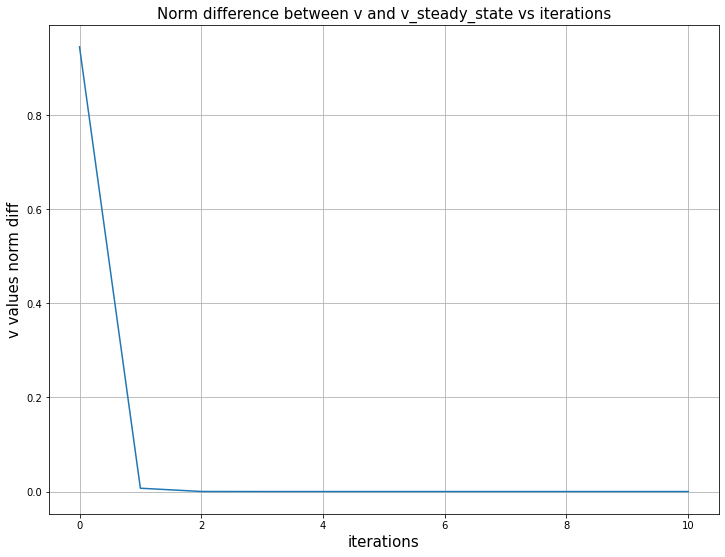

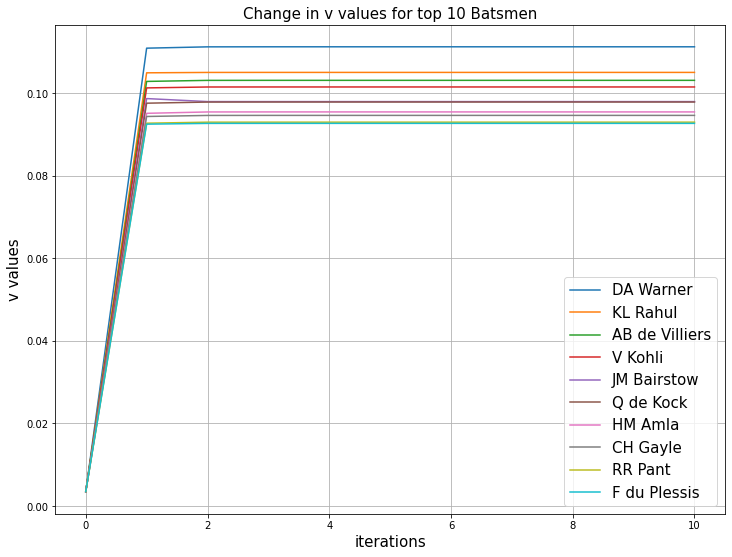

In [20]:
# cell to compute pagerank for batsmen, retrieve top 10 players and plotting their scores over iterations
pagerank_batsman = PageRank(0.1, P_batsman_matrix)
best_batsmen = pagerank_batsman.runPageRank(10, 'Batsmen')
best_batsmen = best_batsmen.tolist()
names = [batsman_list[i] for i in best_batsmen[0]]
pagerank_batsman.plotRanking(names, 'Batsmen')

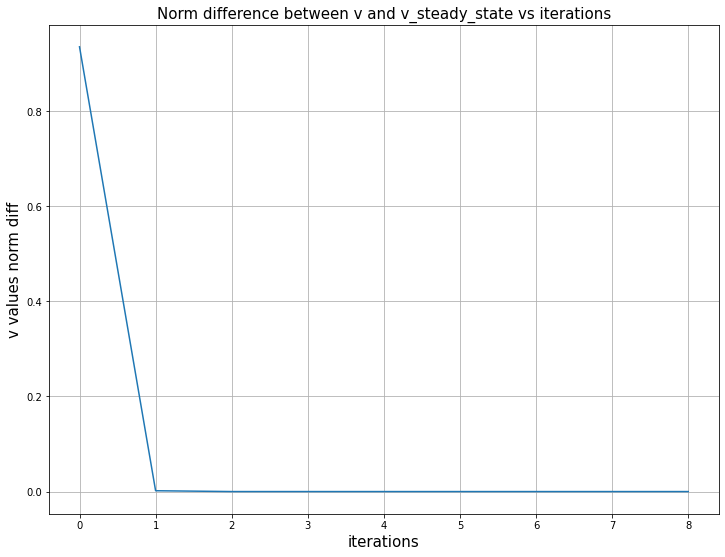

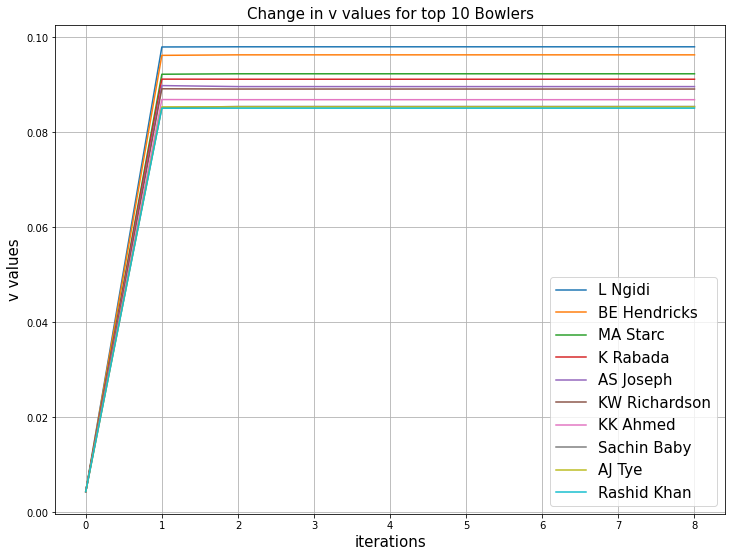

In [21]:
# cell to compute pagerank for bowlers, retrieve top 10 players and plotting their scores over iterations
pagerank_bowler = PageRank(0.1, P_bowler_matrix)
best_bowler = pagerank_bowler.runPageRank(10, 'Bowlers')
best_bowler = best_bowler.tolist()
names = [bowler_list[i] for i in best_bowler[0]]
pagerank_bowler.plotRanking(names, 'Bowlers')